## Спортивный анализ данных. Платформа Kaggle
### Алгоритмы машинного обучения XGBoost, LightGBM, CatBoost

### Практическое задание 2.

* Зафиксировать схему валидации решения и использовать во всех задачах этого задания. 
* Метрика качества - ROC AUC
* Целевая переменная - isFraud.


Ссылка на данные - https://drive.google.com/file/d/1GN6d4_QTYWY-qFdjz_TqxFHIJRi_oTRP/view?usp=sharing

### Содержание <a name = 'outline'></a>
* [I. XGBoost](#XGBoost)
* [II. LightGBM](#LightGBM)
* [III. CatBoost](#CatBoost)
* [IV. ROC-кривая](#ROC_curve)

In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd


import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestRegressor

from imblearn.under_sampling import RandomUnderSampler 
from collections import Counter

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Пути к директориям и файлам

In [3]:
PATH = 'C:/Users/ASER/Desktop/GeekBrains/Kaggle/Lesson_2/data/'
TRAIN_DATASET_PATH = PATH + 'train.csv'
TEST_DATASET_PATH = PATH + 'test.csv'

#### Загрузка данных

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
print('train.shape', train.shape)
train.head(2)

train.shape (180000, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
test = pd.read_csv(TEST_DATASET_PATH)
print('test.shape', test.shape)
test.head(2)

test.shape (100001, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
TARGET_NAME = 'isFraud'

#### Обзор распределения целевой переменной

In [7]:
train[TARGET_NAME].value_counts()

0    174859
1      5141
Name: isFraud, dtype: int64

#### Классификация признаков

In [8]:
INDEPENDENT_VARIABLE_NAMES = train.columns.to_list()[2:]
INDEPENDENT_VARIABLE_NAMES[:3]

['TransactionDT', 'TransactionAmt', 'ProductCD']

In [9]:
NUMERICAL_FEATURE_NAMES = train[INDEPENDENT_VARIABLE_NAMES].select_dtypes(include=[np.number]).columns.to_list()
CATEGORICAL_FEATURE_NAMES = train[INDEPENDENT_VARIABLE_NAMES].select_dtypes(include=[np.object]).columns.to_list()

print(f'count of numerical features {len(NUMERICAL_FEATURE_NAMES)}')
print(f'count of categorical features {len(CATEGORICAL_FEATURE_NAMES)}')

count of numerical features 378
count of categorical features 14


#### Обработка категориальных признаков

In [10]:
class FeatureGenerator:
    def __init__(self, CATEGORICAL_FEATURE_NAMES):
        self.CATEGORICAL_FEATURE_NAMES = CATEGORICAL_FEATURE_NAMES
        self.NEW_CATEGORICAL_FEATURE_NAMES = []
        self.LGB_CATEGORICAL_FEATURE_NAMES = []
        self.target_encodings = dict()
        self.ordinal_encoding = dict()
        
        
    def fit(self, train):
        df = train.copy()
        for feature in self.CATEGORICAL_FEATURE_NAMES: 
            new_feature = feature + '_'
            lgb_feature = feature + 'lgb'
            self.NEW_CATEGORICAL_FEATURE_NAMES.append(new_feature)
            self.LGB_CATEGORICAL_FEATURE_NAMES.append(lgb_feature)            
            self.target_encodings[feature] = {}
            self.ordinal_encoding[feature] = {}
            for ind, level in enumerate(df[feature].unique()):
                level_value = df.loc[df[feature]==level, TARGET_NAME].mean()
                self.target_encodings[feature][level] = level_value
                self.ordinal_encoding[feature][level] = ind
                
    def transform(self, df):
        for feature in self.CATEGORICAL_FEATURE_NAMES: 
            for level in self.target_encodings[feature].keys():
                new_feature = feature + '_'
                lgb_feature = feature + 'lgb'
                df.loc[df[feature] == level, new_feature] = self.target_encodings[feature][level]
                df.loc[df[feature] == level, lgb_feature] = self.ordinal_encoding[feature][level]
                
        df[CATEGORICAL_FEATURE_NAMES] = df[CATEGORICAL_FEATURE_NAMES].astype(str)  
        
        return df

#### Train_test_split

In [11]:
df_train, df_valid = train_test_split(train, 
                                      shuffle=True,
                                      stratify=train[TARGET_NAME],
                                      test_size=0.2,
                                      random_state=1)

#### Генерация признаков

* a) oбучающий датасет

In [12]:
features = FeatureGenerator(CATEGORICAL_FEATURE_NAMES)
features.fit(df_train)
df_train = features.transform(df_train)
df_valid = features.transform(df_valid)

* b) тестовый датасет

In [13]:
features = FeatureGenerator(CATEGORICAL_FEATURE_NAMES)
features.fit(train)
train = features.transform(train)
test = features.transform(test)

[назад к содержанию](#outline)

### I. XGBoost  <a name = 'XGBoost'></a>

#### Задание 1.
Отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

#### XGBoost API

In [14]:
params_xgb = {"booster": "gbtree", 
              "objective": "binary:logistic", 
              "eval_metric": "auc", 
              "learning_rate": 0.1, 
              "n_estimators": 1000, 
              "reg_lambda": 100, 
              "max_depth": 4, 
              "gamma": 10, 
              "nthread": 6, 
              "seed": 27}

In [15]:
dtrain = xgb.DMatrix(data=df_train[NUMERICAL_FEATURE_NAMES], label=df_train[TARGET_NAME])
dvalid = xgb.DMatrix(data=df_valid[NUMERICAL_FEATURE_NAMES], label=df_valid[TARGET_NAME])

model_xgb_num = xgb.train(params=params_xgb,
                          dtrain=dtrain,
                          evals=[(dtrain, "train"), (dvalid, "valid")],
                          num_boost_round=1000,
                          early_stopping_rounds=50,  
                          verbose_eval=50,
                          maximize=True)

[20:27:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.64850	valid-auc:0.65575
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.88045	valid-auc:0.88507
[100]	train-auc:0.89836	valid-auc:0.89863
[150]	train-auc:0.90670	valid-auc:0.90349
[200]	train-auc:0.90770	valid-auc:0.90416
Stopping. Best iteration:
[158]	train-auc:0.90770	valid-auc:0.90416



#### Задание 2.
Oбработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

In [16]:
SELECTED_FEATURE_NAMES = NUMERICAL_FEATURE_NAMES + features.NEW_CATEGORICAL_FEATURE_NAMES

In [17]:
dtrain = xgb.DMatrix(data=df_train[SELECTED_FEATURE_NAMES], label=df_train[TARGET_NAME])
dvalid = xgb.DMatrix(data=df_valid[SELECTED_FEATURE_NAMES], label=df_valid[TARGET_NAME])

model_xgb_all = xgb.train(params=params_xgb,
                          dtrain=dtrain,
                          num_boost_round=1000,
                          early_stopping_rounds=50,
                          evals=[(dtrain, "train"), (dvalid, "valid")],
                          verbose_eval=50,
                          maximize=True)

[20:32:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.64850	valid-auc:0.65575
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.88926	valid-auc:0.89377
[100]	train-auc:0.90965	valid-auc:0.90758
[150]	train-auc:0.91779	valid-auc:0.91230
Stopping. Best iteration:
[147]	train-auc:0.91770	valid-auc:0.91232



[назад к содержанию](#outline)

### II. LightGBM <a name = 'LightGBM'></a>

#### Задание 4.
Для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

#### LightGBM API

In [18]:
params_lgb = {"boosting_type": "gbdt",
              "objective": "binary",
              "metric": "auc",
              "num_boost_round": 10000,  
              "learning_rate": 0.02,
              "n_estimators": 5000,
              "n_jobs": 6,
              "seed": 27}

In [19]:
dtrain = lgb.Dataset(data=df_train[NUMERICAL_FEATURE_NAMES], label=df_train[TARGET_NAME])
dvalid = lgb.Dataset(data=df_valid[NUMERICAL_FEATURE_NAMES], label=df_valid[TARGET_NAME])

model_lgb_num = lgb.train(params=params_lgb,
                          train_set=dtrain,  
                          valid_sets=[dtrain, dvalid],
                          categorical_feature="auto",
                          verbose_eval=500,
                          early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[500]	training's auc: 0.968469	valid_1's auc: 0.936456
[1000]	training's auc: 0.985212	valid_1's auc: 0.944502
[1500]	training's auc: 0.992758	valid_1's auc: 0.948595
[2000]	training's auc: 0.99593	valid_1's auc: 0.951174
[2500]	training's auc: 0.997702	valid_1's auc: 0.953243
Early stopping, best iteration is:
[2751]	training's auc: 0.998474	valid_1's auc: 0.953734


#### Задание 5.
Обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

In [20]:
dtrain = lgb.Dataset(data=df_train[SELECTED_FEATURE_NAMES], label=df_train[TARGET_NAME])
dvalid = lgb.Dataset(data=df_valid[SELECTED_FEATURE_NAMES],  label=df_valid[TARGET_NAME])

model_lgb_all = lgb.train(params=params_lgb,
                          train_set=dtrain, 
                          valid_sets=[dtrain, dvalid],
                          categorical_feature="auto",
                          verbose_eval=500,
                          early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[500]	training's auc: 0.975315	valid_1's auc: 0.943523
[1000]	training's auc: 0.990136	valid_1's auc: 0.951673
[1500]	training's auc: 0.996013	valid_1's auc: 0.955377
[2000]	training's auc: 0.998162	valid_1's auc: 0.957865
Early stopping, best iteration is:
[2015]	training's auc: 0.998195	valid_1's auc: 0.957924


#### Задание 6.
Обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

In [21]:
SELECTED_FEATURE_NAMES_LGB = NUMERICAL_FEATURE_NAMES + features.LGB_CATEGORICAL_FEATURE_NAMES

In [22]:
dtrain = lgb.Dataset(data=df_train[SELECTED_FEATURE_NAMES_LGB], 
                     label=df_train[TARGET_NAME], 
                     categorical_feature=features.LGB_CATEGORICAL_FEATURE_NAMES)

dvalid = lgb.Dataset(data=df_valid[SELECTED_FEATURE_NAMES_LGB], 
                     label=df_valid[TARGET_NAME],
                     categorical_feature=features.LGB_CATEGORICAL_FEATURE_NAMES)

model_lgb_all_cat = lgb.train(params=params_lgb,
                              train_set=dtrain,  
                              valid_sets=[dtrain, dvalid],
                              categorical_feature=features.LGB_CATEGORICAL_FEATURE_NAMES,
                              verbose_eval=500,
                              early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[500]	training's auc: 0.974734	valid_1's auc: 0.944178
[1000]	training's auc: 0.990407	valid_1's auc: 0.951138
[1500]	training's auc: 0.995803	valid_1's auc: 0.955697
[2000]	training's auc: 0.998087	valid_1's auc: 0.957623
Early stopping, best iteration is:
[2410]	training's auc: 0.998923	valid_1's auc: 0.958814


__Вывод:__ Обработка категориальных признаков встроенным в LightGBM методом дает более высокие результаты по сравнению с target encoding, хотя и замедляет работу алгоритма.

[назад к содержанию](#outline)

### III. CatBoost <a name = 'CatBoost'></a>

#### Задание 7.
Для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

#### CatBoost API

In [23]:
params_cb = {"n_estimators":5000,
             "loss_function": "Logloss",
             "eval_metric": "AUC",
             "task_type": "CPU",
             "max_bin": 30,
             "early_stopping_rounds": 50,
             "verbose": 500,
             "max_depth": 6,
             "l2_leaf_reg": 100,             
             "thread_count": 6,
             "random_seed": 42}

In [24]:
dtrain = cb.Pool(df_train[NUMERICAL_FEATURE_NAMES], label=df_train[TARGET_NAME])
dvalid = cb.Pool(df_valid[NUMERICAL_FEATURE_NAMES], label=df_valid[TARGET_NAME])

model_cb_num = cb.CatBoostClassifier(**params_cb)
model_cb_num.fit(dtrain, eval_set=dvalid)

0:	test: 0.6851543	best: 0.6851543 (0)	total: 361ms	remaining: 30m 3s
500:	test: 0.8932886	best: 0.8932886 (500)	total: 1m 29s	remaining: 13m 20s
1000:	test: 0.8951755	best: 0.8951764 (998)	total: 2m 45s	remaining: 11m 1s
1500:	test: 0.8991173	best: 0.8991173 (1500)	total: 4m 5s	remaining: 9m 33s
2000:	test: 0.9022018	best: 0.9022023 (1999)	total: 5m 24s	remaining: 8m 6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9026404837
bestIteration = 2071

Shrink model to first 2072 iterations.


#### Задание 8. 
Обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.

In [25]:
dtrain = cb.Pool(df_train[SELECTED_FEATURE_NAMES], label=df_train[TARGET_NAME])
dvalid = cb.Pool(df_valid[SELECTED_FEATURE_NAMES], label=df_valid[TARGET_NAME])

model_cb_all = cb.CatBoostClassifier(**params_cb)
model_cb_all.fit(dtrain, eval_set=dvalid)

0:	test: 0.6586549	best: 0.6586549 (0)	total: 170ms	remaining: 14m 10s
500:	test: 0.9028284	best: 0.9028320 (497)	total: 1m 29s	remaining: 13m 23s
1000:	test: 0.9042180	best: 0.9042194 (975)	total: 2m 44s	remaining: 10m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9096954885
bestIteration = 1420

Shrink model to first 1421 iterations.


#### Задание 9.
Обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

In [26]:
dtrain = cb.Pool(df_train[INDEPENDENT_VARIABLE_NAMES], 
                 label=df_train[TARGET_NAME], 
                 cat_features=CATEGORICAL_FEATURE_NAMES)
dvalid = cb.Pool(df_valid[INDEPENDENT_VARIABLE_NAMES], 
                 df_valid[TARGET_NAME], 
                 cat_features=CATEGORICAL_FEATURE_NAMES)

model_cb_all_cat = cb.CatBoostClassifier(**params_cb)
model_cb_all_cat.fit(dtrain, eval_set=dvalid)

0:	test: 0.7604251	best: 0.7604251 (0)	total: 734ms	remaining: 1h 1m 9s
500:	test: 0.9010051	best: 0.9010052 (497)	total: 5m 49s	remaining: 52m 21s
1000:	test: 0.9047181	best: 0.9047181 (1000)	total: 11m 11s	remaining: 44m 43s
1500:	test: 0.9096160	best: 0.9096163 (1497)	total: 16m 44s	remaining: 39m
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9114032749
bestIteration = 1848

Shrink model to first 1849 iterations.


__Вывод:__ Обработка категориальных признаков встроенным в CatBoost методом дает более высокие результаты по сравнению с target encoding, хотя и замедляет работу алгоритма.

[назад к содержанию](#outline)

### IV. ROC- кривая <a name = 'ROC_curve'></a>

#### Задание 10. 
Построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

In [27]:
def plot_ROC_curve(predictions):
    plt.figure(figsize=(8, 6))
    y = [train[TARGET_NAME], test[TARGET_NAME]]
    labels = ['train', 'test']

    for i, y_pred in enumerate(predictions):
        fpr, tpr, _ = roc_curve(y[i], y_pred)
        auc = round(roc_auc_score(y[i], y_pred), 3)
        plt.plot(fpr, tpr, label=f'{labels[i]}, auc={auc}')

    plt.title('ROC-кривые', size=14)
    plt.legend()
    plt.show()

#### 1. Модели XGBoost

#### 1.1. Только числовые признаки

In [28]:
dtrain = xgb.DMatrix(data=train[NUMERICAL_FEATURE_NAMES], label=train[TARGET_NAME])
dtest = xgb.DMatrix(data=test[NUMERICAL_FEATURE_NAMES], label=test[TARGET_NAME])

model_xgb_num = xgb.train(params=params_xgb,
                          dtrain=dtrain,
                          evals=[(dtrain, 'train'), (dtest, 'test')],
                          num_boost_round=1000,
                          early_stopping_rounds=50,  
                          verbose_eval=50,
                          maximize=True)

y_pred_xgb_num_train = model_xgb_num.predict(dtrain)
y_pred_xgb_num_test = model_xgb_num.predict(dtest)

[21:31:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.64999	test-auc:0.62240
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.88296	test-auc:0.85165
[100]	train-auc:0.90023	test-auc:0.85606
[150]	train-auc:0.90822	test-auc:0.85821
[200]	train-auc:0.91227	test-auc:0.85983
Stopping. Best iteration:
[182]	train-auc:0.91196	test-auc:0.85984



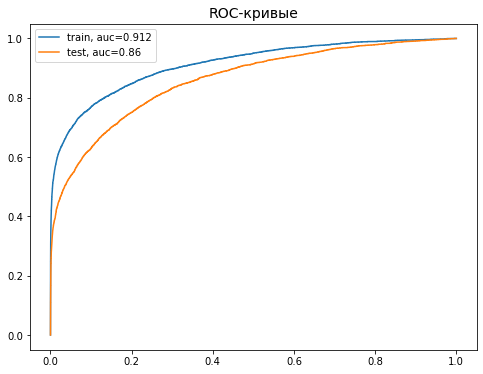

In [29]:
predictions = y_pred_xgb_num_train, y_pred_xgb_num_test
plot_ROC_curve(predictions)

#### 1.2. К числовым признакам добавлены категориальные признаки, обработанные методом target encooding

In [30]:
dtrain = xgb.DMatrix(data=train[SELECTED_FEATURE_NAMES], label=train[TARGET_NAME])
dtest = xgb.DMatrix(data=test[SELECTED_FEATURE_NAMES], label=test[TARGET_NAME])

model_xgb_all = xgb.train(params=params_xgb,
                          dtrain=dtrain,
                          num_boost_round=1000,
                          early_stopping_rounds=50,
                          evals=[(dtrain, 'train'), (dtest, 'test')],
                          verbose_eval=50,
                          maximize=True)

y_pred_xgb_all_train = model_xgb_all.predict(dtrain)
y_pred_xgb_all_test = model_xgb_all.predict(dtest)

[21:38:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.64998	test-auc:0.62239
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.89128	test-auc:0.85427
[100]	train-auc:0.91061	test-auc:0.86120
[150]	train-auc:0.91810	test-auc:0.86483
[200]	train-auc:0.92075	test-auc:0.86547
Stopping. Best iteration:
[170]	train-auc:0.92026	test-auc:0.86549



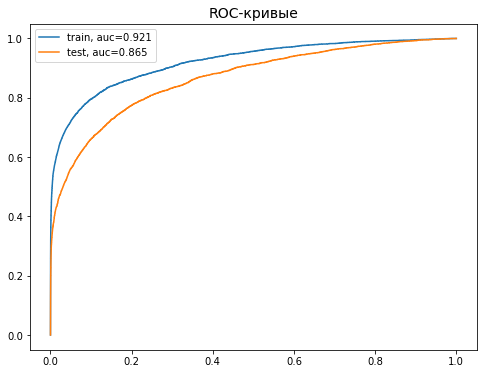

In [31]:
predictions = y_pred_xgb_all_train, y_pred_xgb_all_test
plot_ROC_curve(predictions)

#### 2. Модели LightGBM

#### 2.1 Только числовые признаки

In [32]:
dtrain = lgb.Dataset(data=train[NUMERICAL_FEATURE_NAMES], label=train[TARGET_NAME])
dtest = lgb.Dataset(data=test[NUMERICAL_FEATURE_NAMES], label=test[TARGET_NAME])

model_lgb_num = lgb.train(params=params_lgb,
                          train_set=dtrain,  
                          valid_sets=[dtrain, dtest],
                          categorical_feature='auto',
                          verbose_eval=500,
                          early_stopping_rounds=50)

y_pred_lgb_num_train = model_lgb_num.predict(train[NUMERICAL_FEATURE_NAMES])
y_pred_lgb_num_test = model_lgb_num.predict(test[NUMERICAL_FEATURE_NAMES])

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	training's auc: 0.895374	valid_1's auc: 0.856907


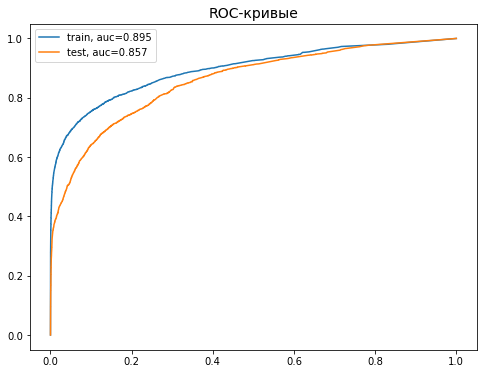

In [33]:
predictions = y_pred_lgb_num_train, y_pred_lgb_num_test
plot_ROC_curve(predictions)

#### 2.2. К числовым признакам добавлены категориальные признаки, обработанные методом target encooding

In [34]:
dtrain = lgb.Dataset(data=train[SELECTED_FEATURE_NAMES], label=train[TARGET_NAME])
dtest = lgb.Dataset(data=test[SELECTED_FEATURE_NAMES], label=test[TARGET_NAME])

model_lgb_all = lgb.train(params=params_lgb,
                          train_set=dtrain, 
                          valid_sets=[dtrain, dtest],
                          categorical_feature='auto',
                          verbose_eval=500,
                          early_stopping_rounds=50)

y_pred_lgb_all_train = model_lgb_all.predict(train[SELECTED_FEATURE_NAMES])
y_pred_lgb_all_test = model_lgb_all.predict(test[SELECTED_FEATURE_NAMES])

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[309]	training's auc: 0.958758	valid_1's auc: 0.872195


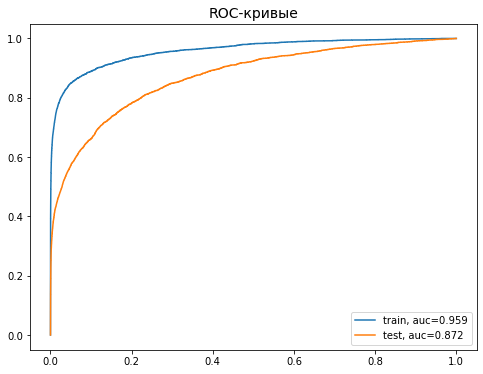

In [35]:
predictions = y_pred_lgb_all_train, y_pred_lgb_all_test
plot_ROC_curve(predictions)

#### 2.3. К числовым признакам добавлены обработанные встроенным в LightGBM методом категориальные признаки

In [36]:
dtrain = lgb.Dataset(data=train[SELECTED_FEATURE_NAMES_LGB], 
                     label=train[TARGET_NAME], 
                     categorical_feature=features.LGB_CATEGORICAL_FEATURE_NAMES)

dtest = lgb.Dataset(data=test[SELECTED_FEATURE_NAMES_LGB], 
                    label=test[TARGET_NAME],
                    categorical_feature=features.LGB_CATEGORICAL_FEATURE_NAMES)


model_lgb_all_cat = lgb.train(params=params_lgb,
                              train_set=dtrain,  
                              valid_sets=[dtrain, dtest],
                              categorical_feature=features.LGB_CATEGORICAL_FEATURE_NAMES,
                              verbose_eval=500,
                              early_stopping_rounds=50)

y_pred_lgb_all_cat_train = model_lgb_all_cat.predict(train[SELECTED_FEATURE_NAMES_LGB])
y_pred_lgb_all_cat_test = model_lgb_all_cat.predict(test[SELECTED_FEATURE_NAMES_LGB])

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[385]	training's auc: 0.965812	valid_1's auc: 0.872888


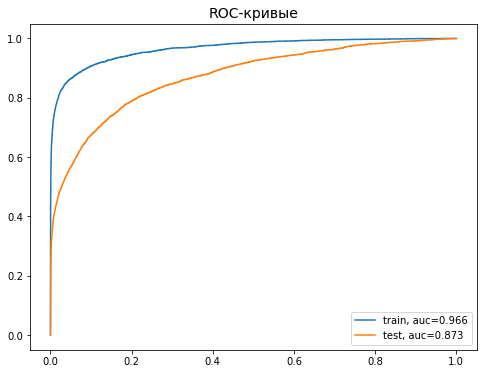

In [37]:
predictions = y_pred_lgb_all_cat_train, y_pred_lgb_all_cat_test
plot_ROC_curve(predictions)

#### 3. Модели CatBoost

#### 3.1. Только числовые признаки

In [38]:
dtrain = cb.Pool(train[NUMERICAL_FEATURE_NAMES], label=train[TARGET_NAME])
dtest = cb.Pool(test[NUMERICAL_FEATURE_NAMES], label=test[TARGET_NAME])

model_cb_num = cb.CatBoostClassifier(**params_cb)
model_cb_num.fit(dtrain, eval_set=dtest)

y_pred_cb_num_train = model_cb_num.predict(train[NUMERICAL_FEATURE_NAMES])
y_pred_cb_num_test = model_cb_num.predict(test[NUMERICAL_FEATURE_NAMES])

0:	test: 0.5947287	best: 0.5947287 (0)	total: 197ms	remaining: 16m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8565824322
bestIteration = 425

Shrink model to first 426 iterations.


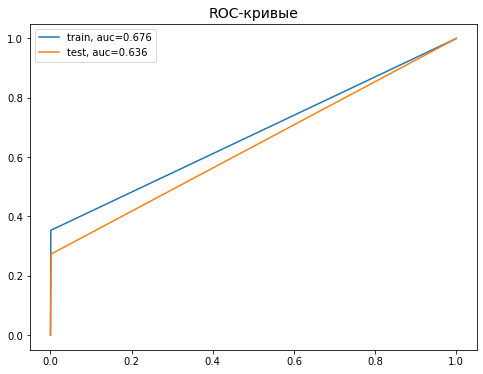

In [39]:
predictions = y_pred_cb_num_train, y_pred_cb_num_test
plot_ROC_curve(predictions)

#### 3.2. К числовым признакам добавлены категориальные признаки, обработанные методом target encooding

In [40]:
dtrain = cb.Pool(train[SELECTED_FEATURE_NAMES], label=train[TARGET_NAME])
dtest = cb.Pool(test[SELECTED_FEATURE_NAMES], label=test[TARGET_NAME])

model_cb_all = cb.CatBoostClassifier(**params_cb)
model_cb_all.fit(dtrain, eval_set=dtest)

y_pred_cb_all_train = model_cb_all.predict(train[SELECTED_FEATURE_NAMES])
y_pred_cb_all_test = model_cb_all.predict(test[SELECTED_FEATURE_NAMES])

0:	test: 0.6524721	best: 0.6524721 (0)	total: 224ms	remaining: 18m 42s
500:	test: 0.8637130	best: 0.8637159 (499)	total: 1m 51s	remaining: 16m 44s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.864513019
bestIteration = 571

Shrink model to first 572 iterations.


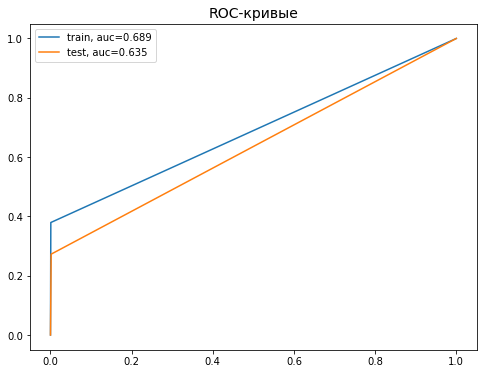

In [41]:
predictions = y_pred_cb_all_train, y_pred_cb_all_test
plot_ROC_curve(predictions)

#### 3.3. К числовым признакам добавлены обработанные встроенным в CatBoost методом категориальные признаки

In [42]:
dtrain = cb.Pool(train[INDEPENDENT_VARIABLE_NAMES], 
                 label=train[TARGET_NAME], 
                 cat_features=CATEGORICAL_FEATURE_NAMES)

dtest = cb.Pool(test[INDEPENDENT_VARIABLE_NAMES], 
                label=test[TARGET_NAME], 
                cat_features=CATEGORICAL_FEATURE_NAMES)

model_cb_all_cat = cb.CatBoostClassifier(**params_cb)
model_cb_all_cat.fit(dtrain, eval_set=dtest)

y_pred_cb_all_cat_train = model_cb_all_cat.predict(train[INDEPENDENT_VARIABLE_NAMES])
y_pred_cb_all_cat_test = model_cb_all_cat.predict(test[INDEPENDENT_VARIABLE_NAMES])

0:	test: 0.5884172	best: 0.5884172 (0)	total: 1.01s	remaining: 1h 24m 29s
500:	test: 0.8628172	best: 0.8628397 (498)	total: 7m 48s	remaining: 1h 10m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8650966252
bestIteration = 722

Shrink model to first 723 iterations.


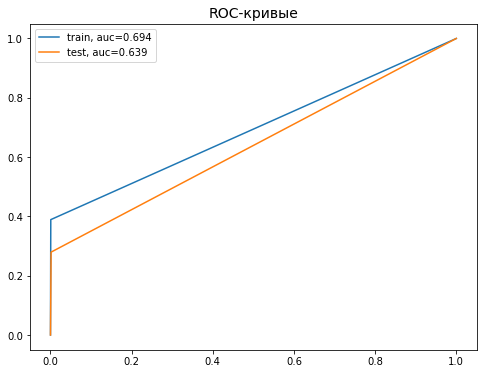

In [43]:
predictions = y_pred_cb_all_cat_train, y_pred_cb_all_cat_test
plot_ROC_curve(predictions)

__Вывод:__ На тестовой выборке алгоритмы работают значительно хуже, чем на обучающей. С одной стороны, это могло бы указывать на переобучение: мы вычисляем остатки для каждого наблюдения из обучающей выборки, используя модель, которая была обучена на том же наборе данных. Однако, на валидационном и обучающем сетах разница в результатах работы алгоритмов была существенно ниже. Соответственно, из факторов, объясняющих относительно низкие результаты работы алгоритмов на тестовой выборке по сравнению с обучающей, на первое место выходит не переобучение модели, а разница в распределении признаков тестового и обучающего датасетов.

[назад к содержанию](#outline)